In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating fluid cognition and parental education level
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_fluidcomp_uncorrected','reshist_addr1_adi_edu_high','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [9]:
val=data['reshist_addr1_adi_edu_high'].median()
data.loc[data['reshist_addr1_adi_edu_high'] <= val, 'reshist_addr1_adi_edu_high_bin'] = 0
data.loc[data['reshist_addr1_adi_edu_high'] > val, 'reshist_addr1_adi_edu_high_bin'] = 1

In [10]:
data['nihtbx_fluidcomp_uncorrected_log']= np.log(data['nihtbx_fluidcomp_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_fluidcomp_uncorrected_log'
data['nihtbx_fluidcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [11]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [13]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
edu = data.reshist_addr1_adi_edu_high_bin.values
target_values = data.nihtbx_fluidcomp_uncorrected_zscore.values

In [14]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
edu_ = shared(edu)

In [15]:
#varying intercepts and varying slopes: 
#predicting fluid cognition scores from census education level 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * edu_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 561 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


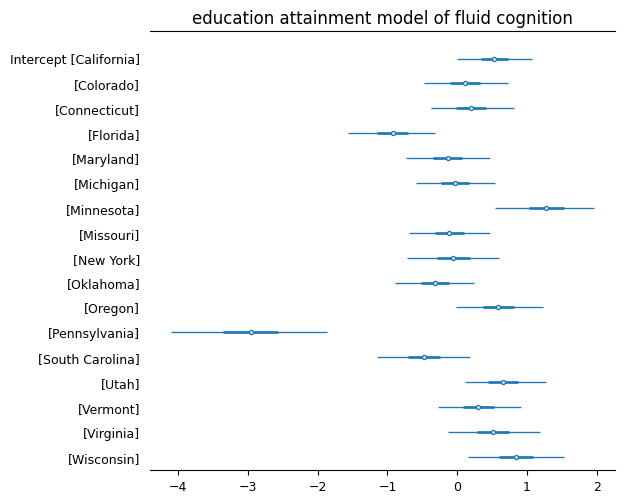

In [16]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("education attainment model of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_edu_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_90363/1228826586.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


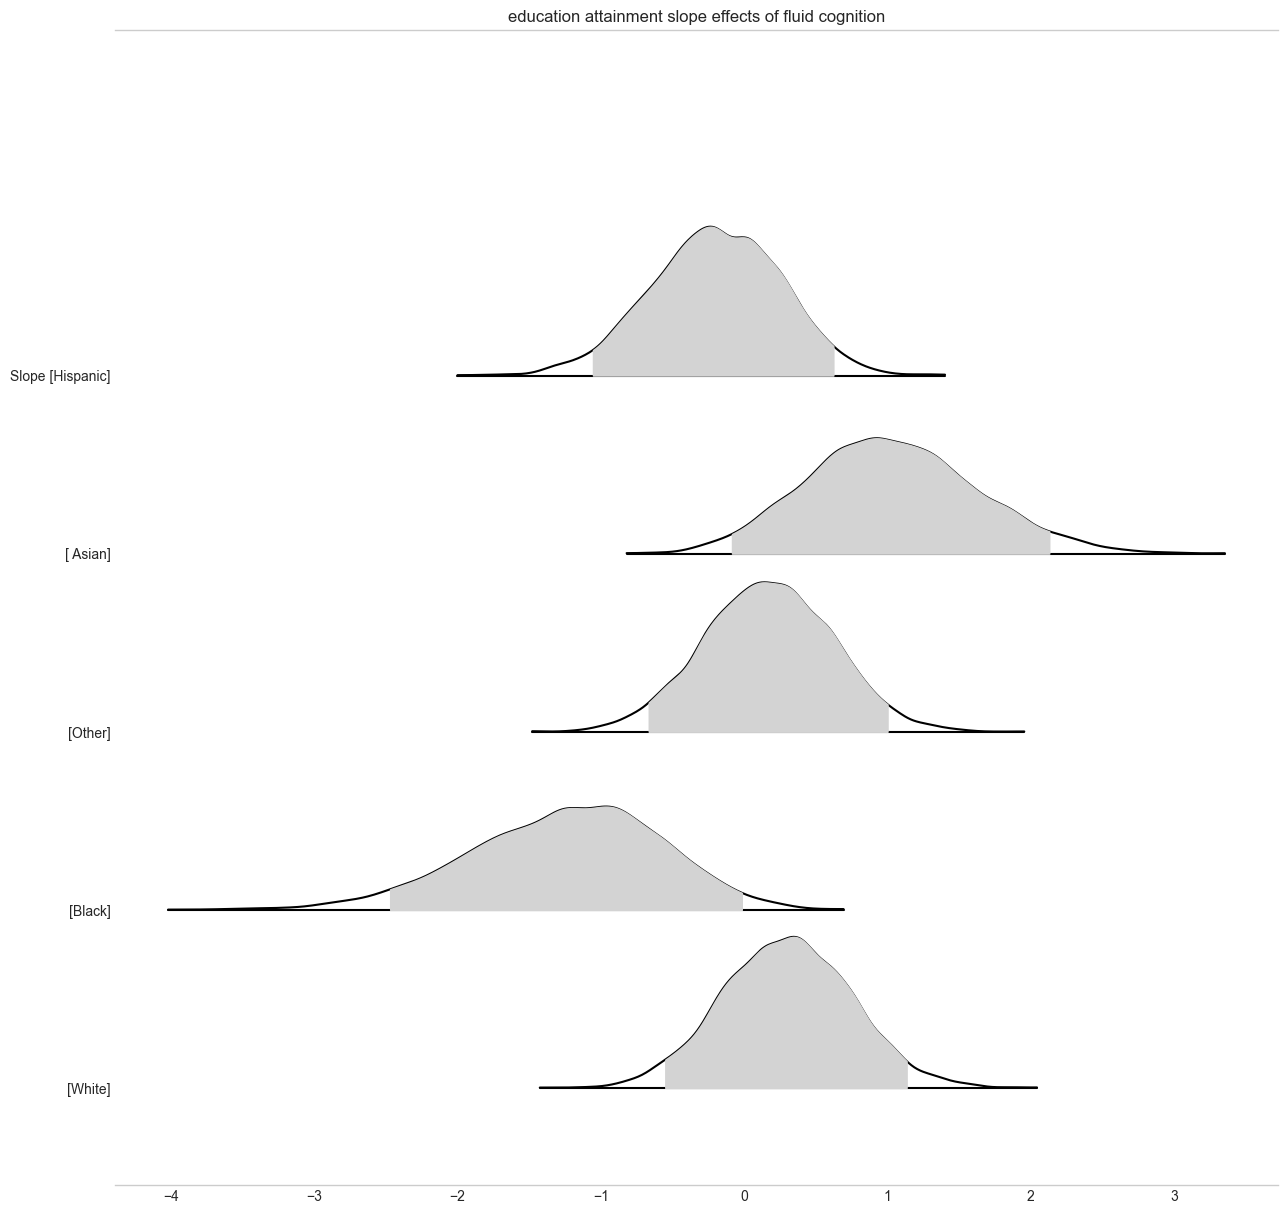

In [17]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("education attainment slope effects of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_edu_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [18]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [19]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.352019
r2_std    0.003309
dtype: float64

In [20]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [21]:
# get race, state and parental education attain columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_edu_df = pd.DataFrame(data['reshist_addr1_adi_edu_high_bin'],columns =['reshist_addr1_adi_edu_high_bin']).reset_index(drop=True)


In [22]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_edu_df,ppc_df,left_index=True, right_index=True)


In [23]:
ppc_edu_race_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.150416  0.019875 -0.155016   
                               Black          -0.202979 -0.254099 -0.294994   
                               Hispanic       -0.127753 -0.196623 -0.200173   
                               Other          -0.140914 -0.274809 -0.213147   
                               White          -0.134092 -0.182956 -0.161274   
1.0                            Asian           0.457441  0.491341  0.463865   
                               Black          -0.373859 -0.477572 -0.363340   
                               Hispanic       -0.067085 -0.016296  0.018553   
                               Other           0.251670  0.223114  0.164426   
                               White           0.292367  0.250163  0.288772   

                                               pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.061165 -0.202395 -0.376057   
                               Black          -0.247398 -0.284043 -0.326058   
                               Hispanic       -0.123278 -0.153520 -0.208030   
                               Other          -0.184155 -0.177644 -0.212805   
                               White          -0.144116 -0.132226 -0.172240   
1.0                            Asian           0.380808  0.448682  0.533785   
                               Black          -0.378597 -0.420034 -0.365151   
                               Hispanic        0.097172  0.071935 -0.067239   
                               Other           0.220498  0.164974  0.084772   
                               White           0.272202  0.269668  0.224574   

                                               pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.129736 -0.107691 -0.166029   
                               Black          -0.312695 -0.266179 -0.312374   
                               Hispanic       -0.187107 -0.182912 -0.193043   
                               Other          -0.157103 -0.256928 -0.250737   
                               White          -0.142300 -0.123761 -0.164550   
1.0                            Asian           0.443268  0.523757  0.707806   
                               Black          -0.341832 -0.397151 -0.471673   
                               Hispanic        0.119461  0.049739  0.073035   
                               Other           0.065035  0.129775  0.219281   
                               White           0.272172  0.296985  0.280894   

                                               pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_edu_high_bin race_ethnicity            ...                
0.0                            Asian          -0.065073  ...    -0.233505   
                               Black          -0.289402  ...    -0.280329   
                               Hispanic       -0.169111  ...    -0.170418   
                               Other          -0.275862  ...    -0.195155   
                               White          -0.177793  ...    -0.177871   
1.0                            Asian           0.533031  ...     0.524088   
                               Black          -0.321074  ...    -0.471318   
                               Hispanic        0.144066  ...    -0.036332   
                               Other           0.201148  ...     0.183400   
                               White           0.271037  ...     0.280225   

                                               pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_edu_high_bin race_ethnicity                             
0.0                            Asian             -0.101663    -0.085698   
                               Black             -

In [24]:
ppc_edu_race_mean_summ=ppc_edu_race_mean.mean(axis=1)
ppc_edu_race_mean_summ

reshist_addr1_adi_edu_high_bin  race_ethnicity
0.0                             Asian            -0.107719
                                Black            -0.288226
                                Hispanic         -0.170857
                                Other            -0.207244
                                White            -0.163299
1.0                             Asian             0.549587
                                Black            -0.414686
                                Hispanic          0.045606
                                Other             0.182865
                                White             0.256768
dtype: float64

In [25]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.241998,0.324239,0.244515,0.224159,0.217920,0.211309,0.240178,0.299953,0.398092,0.321045,...,0.255574,0.301499,0.362906,0.238625,0.363298,0.420804,0.336801,0.316953,0.344726,0.180274
Black,-0.237894,-0.299759,-0.308958,-0.274205,-0.311829,-0.334045,-0.318649,-0.292939,-0.344922,-0.295873,...,-0.319353,-0.353410,-0.339328,-0.277967,-0.317024,-0.354501,-0.335693,-0.345405,-0.240819,-0.362990
Hispanic,-0.113052,-0.152925,-0.147170,-0.069857,-0.098886,-0.173913,-0.112817,-0.126535,-0.128565,-0.093220,...,-0.137925,-0.057215,-0.080562,-0.121515,-0.054487,-0.153884,-0.134750,-0.111021,-0.119181,-0.093840
Other,0.062841,-0.016382,-0.017183,0.025864,0.000178,-0.058360,-0.041811,-0.056226,-0.006793,-0.028289,...,0.001319,-0.023192,0.011904,-0.023582,0.001095,-0.032587,-0.006111,-0.015435,0.008122,0.010693
White,0.149228,0.104788,0.137716,0.132466,0.134774,0.091385,0.133056,0.155763,0.131382,0.120389,...,0.126467,0.088114,0.110189,0.137112,0.094820,0.082654,0.082073,0.100706,0.085684,0.112595


In [26]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [27]:
ppc_edu_state_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_state_mean_summ = ppc_edu_state_mean.mean(axis=1)


In [28]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [29]:
ppc_edu_state_mean_summ_list=ppc_edu_state_mean_summ.to_numpy()
low_edu_state = ppc_edu_state_mean_summ_list[:17]
high_edu_state = ppc_edu_state_mean_summ_list[-17:]

In [30]:
mean_predictions_state = [low_edu_state,high_edu_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.073513,-0.155463,-0.136645,-0.358746,-0.202896,-0.184023,0.074181,-0.198861,-0.188970,-0.241312,-0.061759,-0.761726,-0.272620,-0.047720,-0.120501,-0.075049,-0.009840
1,0.279981,0.190444,0.187657,-0.087353,0.087413,0.114148,0.410865,0.051185,0.162426,0.085103,0.285942,-0.498545,0.032899,0.309332,0.257239,0.221194,0.335118


In [31]:
ppc_edu_race_mean_summ_list=ppc_edu_race_mean_summ.to_numpy()
low_edu_race = ppc_edu_race_mean_summ_list[:5]
high_edu_race = ppc_edu_race_mean_summ_list[-5:]

In [32]:
# initialize list of lists 
mean_predictions_race = [low_edu_race,high_edu_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.107719,-0.288226,-0.170857,-0.207244,-0.163299
1,0.549587,-0.414686,0.045606,0.182865,0.256768


In [33]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset2.csv', usecols=['state','Education_LT12years_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [34]:
val = census_data['Education_LT12years_score'].median()
census_data.loc[census_data['Education_LT12years_score'] < val, 'Education_LT12years_score_bin'] = 0
census_data.loc[census_data['Education_LT12years_score'] >= val, 'Education_LT12years_score_bin'] = 1

In [35]:
census = (census_data.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0.0,1199488
1,california,Asian,1.0,836906
2,california,Black,1.0,3379985
3,california,Hispanic,0.0,431498
4,california,Hispanic,1.0,21591905
...,...,...,...,...
124,wisconsin,Hispanic,0.0,113805
125,wisconsin,Hispanic,1.0,34579
126,wisconsin,Other,0.0,117894
127,wisconsin,White,0.0,4297676


In [36]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,1199488,1,0
1,california,Asian,1.0,836906,1,0
2,california,Black,1.0,3379985,3,0
3,california,Hispanic,0.0,431498,0,0
4,california,Hispanic,1.0,21591905,0,0


In [37]:
#fix theano shared tensor type error
census=census.astype({'Education_LT12years_score_bin':'uint8'})

In [38]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_edu = census.Education_LT12years_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
edu_.set_value(ps_edu)

In [39]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [40]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(129, 8000)

In [41]:
censust=census
censust

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0,1199488,1,0
1,california,Asian,1,836906,1,0
2,california,Black,1,3379985,3,0
3,california,Hispanic,0,431498,0,0
4,california,Hispanic,1,21591905,0,0
...,...,...,...,...,...,...
124,wisconsin,Hispanic,0,113805,0,16
125,wisconsin,Hispanic,1,34579,0,16
126,wisconsin,Other,0,117894,2,16
127,wisconsin,White,0,4297676,4,16


In [42]:
# get race, state, and parental education attainment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_edu_df2 = pd.DataFrame(censust['Education_LT12years_score_bin'],columns =['Education_LT12years_score_bin']).reset_index(drop=True)


In [43]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_edu_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1199488,-0.635585,-1.545622,-1.507448,-0.449367,0.943119,-0.186294,...,-0.355587,0.871995,-0.433271,0.094158,1.200982,1.452345,0.573002,0.226227,-1.252270,0.083106
1,california,Asian,1,836906,-0.034806,0.273259,0.523510,1.105828,0.878085,0.463270,...,-1.804765,0.954637,0.750544,1.132100,2.268069,1.604288,-1.029388,-0.820655,1.440208,1.591523
2,california,Black,1,3379985,0.567902,0.436836,-2.400253,0.100075,-0.243240,-1.272728,...,-0.313930,-0.269484,0.549635,0.912399,-0.190236,-0.365421,-1.471127,-0.304152,-0.633505,1.232623
3,california,Hispanic,0,431498,-0.199339,-0.672756,0.256458,-0.867721,-1.364099,-1.218045,...,0.223527,-0.039988,-0.372282,-1.153195,-0.391717,0.062427,-1.038689,-0.915792,0.752314,1.448682
4,california,Hispanic,1,21591905,0.123842,0.298200,-0.819323,-1.298051,0.726201,0.685099,...,-0.084301,-1.619205,-0.596108,0.449524,-1.039811,-0.161604,-0.271879,0.554076,-0.266208,-1.220379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,wisconsin,Hispanic,0,113805,-0.471102,0.654308,-0.757593,0.473041,-0.038940,1.312783,...,0.026736,-0.324804,-0.535007,0.364065,0.437514,0.382194,0.306032,-1.355114,-0.642996,0.041435
125,wisconsin,Hispanic,1,34579,0.703604,-1.177255,-0.155402,0.492950,-0.073951,-1.587799,...,0.045544,1.579206,-0.562909,-0.950936,-1.297947,0.542757,0.911359,-0.500545,1.080505,0.297742
126,wisconsin,Other,0,117894,-0.243791,0.184312,-1.499145,-0.431896,-1.197207,-0.112996,...,0.468591,-0.712165,-0.394168,-1.714922,1.786109,0.030090,0.423515,1.027326,-0.360451,-0.259028
127,wisconsin,White,0,4297676,0.985353,-0.399274,-1.964845,1.220235,-0.594816,-1.102366,...,-0.359273,0.385802,-0.003282,0.031003,1.526845,0.164590,-2.584562,-0.922712,0.178860,-0.498624


In [44]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -7.623770e+05   
                          1                             1   -2.912930e+04   
           Black          1                             2    1.919500e+06   
           Hispanic       0                             3   -8.601429e+04   
                          1                             4    2.673993e+06   
...                                                                   ...   
wisconsin  Hispanic       0                             124 -5.361377e+04   
                          1                             125  2.432991e+04   
           Other          0                             126 -2.874153e+04   
           White          0                             127  4.234727e+06   
                          1                             128 -6.634501e+05   

                                                                 pp_cog_1  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.853955e+06   
                          1                             1    2.286921e+05   
           Black          1                             2    1.476499e+06   
           Hispanic       0                             3   -2.902929e+05   
                          1                             4    6.438713e+06   
...                                                                   ...   
wisconsin  Hispanic       0                             124  7.446350e+04   
                          1                             125 -4.070832e+04   
           Other          0                             126  2.172924e+04   
           White          0                             127 -1.715951e+06   
                          1                             128  2.200912e+06   

                                                                 pp_cog_2  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.808166e+06   
                          1                             1    4.381291e+05   
           Black          1                             2   -8.112820e+06   
           Hispanic       0                             3    1.106609e+05   
                          1                             4   -1.769075e+07   
...                                                                   ...   
wisconsin  Hispanic       0                             124 -8.621791e+04   
                          1                             125 -5.373629e+03   
           Other          0                             126 -1.767402e+05   
           White          0                             127 -8.444266e+06   
                          1                             128  2.517823e+05   

                                                                 pp_cog_3  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -5.390103e+05   
                          1                             1    9.254744e+05   
           Black          1                             2    3.382529e+05   
           Hispanic       0                             3   -3.744198e+05   
                          1                             4   -2.802740e+07   
...                                                                   ...   
wisconsin  Hispanic       0                             124  5.383442e+04   
                          1                             125  1.704571e+04   
           Other          0                             126 -5.091798e+04   
           White          0                             127  5.244176e+06   
                          1                             128 -1.526094e+06   

                                                         

In [45]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-7.623770e+05,-1.853955e+06,-1.808166e+06,-5.390103e+05,1.131260e+06,-2.234570e+05,1.272922e+06,-1.286686e+06,-1.728581e+06,1.026532e+06,...,-4.265224e+05,1.045948e+06,-5.197031e+05,1.129417e+05,1.440563e+06,1.742071e+06,6.873087e+05,2.713560e+05,-1.502083e+06,9.968456e+04
1,-2.912930e+04,2.286921e+05,4.381291e+05,9.254744e+05,7.348747e+05,3.877137e+05,1.418435e+06,-1.089034e+04,1.201300e+06,1.260442e+06,...,-1.510419e+06,7.989410e+05,6.281348e+05,9.474610e+05,1.898161e+06,1.342638e+06,-8.615008e+05,-6.868109e+05,1.205318e+06,1.331955e+06
2,1.919500e+06,1.476499e+06,-8.112820e+06,3.382529e+05,-8.221485e+05,-4.301803e+06,1.516573e+05,-2.023724e+06,-3.264875e+06,-1.095321e+06,...,-1.061078e+06,-9.108522e+05,1.857759e+06,3.083893e+06,-6.429958e+05,-1.235116e+06,-4.972386e+06,-1.028029e+06,-2.141239e+06,4.166246e+06
3,-8.601429e+04,-2.902929e+05,1.106609e+05,-3.744198e+05,-5.886060e+05,-5.255839e+05,-7.566792e+04,2.027596e+04,-3.314709e+05,1.587173e+05,...,9.645126e+04,-1.725454e+04,-1.606389e+05,-4.976014e+05,-1.690249e+05,2.693698e+04,-4.481923e+05,-3.951625e+05,3.246221e+05,6.251033e+05
4,2.673993e+06,6.438713e+06,-1.769075e+07,-2.802740e+07,1.568007e+07,1.479258e+07,3.690746e+07,-1.893648e+07,2.463782e+06,1.153148e+07,...,-1.820214e+06,-3.496172e+07,-1.287110e+07,9.706082e+06,-2.245151e+07,-3.489341e+06,-5.870386e+06,1.196356e+07,-5.747935e+06,-2.635031e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,-5.361377e+04,7.446350e+04,-8.621791e+04,5.383442e+04,-4.431581e+03,1.494013e+05,-6.269642e+04,1.189366e+05,-2.213745e+05,-1.715842e+05,...,3.042744e+03,-3.696434e+04,-6.088647e+04,4.143236e+04,4.979133e+04,4.349559e+04,3.482794e+04,-1.542187e+05,-7.317613e+04,4.715473e+03
125,2.432991e+04,-4.070832e+04,-5.373629e+03,1.704571e+04,-2.557166e+03,-5.490451e+04,2.251762e+04,1.350131e+04,-2.381927e+04,5.427136e+04,...,1.574869e+03,5.460738e+04,-1.946483e+04,-3.288243e+04,-4.488172e+04,1.876798e+04,3.151390e+04,-1.730833e+04,3.736278e+04,1.029562e+04
126,-2.874153e+04,2.172924e+04,-1.767402e+05,-5.091798e+04,-1.411435e+05,-1.332151e+04,6.434555e+04,1.297896e+05,2.291894e+04,-9.668961e+03,...,5.524406e+04,-8.395997e+04,-4.647002e+04,-2.021790e+05,2.105716e+05,3.547488e+03,4.992992e+04,1.211156e+05,-4.249496e+04,-3.053784e+04
127,4.234727e+06,-1.715951e+06,-8.444266e+06,5.244176e+06,-2.556325e+06,-4.737612e+06,-5.037548e+06,-3.260412e+06,1.786048e+06,3.498891e+06,...,-1.544038e+06,1.658054e+06,-1.410656e+04,1.332429e+05,6.561886e+06,7.073527e+05,-1.110761e+07,-3.965519e+06,7.686817e+05,-2.142926e+06


In [46]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0,1199488
1,california,Asian,1,836906
2,california,Black,1,3379985
3,california,Hispanic,0,431498
4,california,Hispanic,1,21591905
...,...,...,...,...
124,wisconsin,Hispanic,0,113805
125,wisconsin,Hispanic,1,34579
126,wisconsin,Other,0,117894
127,wisconsin,White,0,4297676


In [47]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1199488,-7.623770e+05,-1.853955e+06,-1.808166e+06,-5.390103e+05,1.131260e+06,-2.234570e+05,...,-4.265224e+05,1.045948e+06,-5.197031e+05,1.129417e+05,1.440563e+06,1.742071e+06,6.873087e+05,2.713560e+05,-1.502083e+06,9.968456e+04
1,california,Asian,1,836906,-2.912930e+04,2.286921e+05,4.381291e+05,9.254744e+05,7.348747e+05,3.877137e+05,...,-1.510419e+06,7.989410e+05,6.281348e+05,9.474610e+05,1.898161e+06,1.342638e+06,-8.615008e+05,-6.868109e+05,1.205318e+06,1.331955e+06
2,california,Black,1,3379985,1.919500e+06,1.476499e+06,-8.112820e+06,3.382529e+05,-8.221485e+05,-4.301803e+06,...,-1.061078e+06,-9.108522e+05,1.857759e+06,3.083893e+06,-6.429958e+05,-1.235116e+06,-4.972386e+06,-1.028029e+06,-2.141239e+06,4.166246e+06
3,california,Hispanic,0,431498,-8.601429e+04,-2.902929e+05,1.106609e+05,-3.744198e+05,-5.886060e+05,-5.255839e+05,...,9.645126e+04,-1.725454e+04,-1.606389e+05,-4.976014e+05,-1.690249e+05,2.693698e+04,-4.481923e+05,-3.951625e+05,3.246221e+05,6.251033e+05
4,california,Hispanic,1,21591905,2.673993e+06,6.438713e+06,-1.769075e+07,-2.802740e+07,1.568007e+07,1.479258e+07,...,-1.820214e+06,-3.496172e+07,-1.287110e+07,9.706082e+06,-2.245151e+07,-3.489341e+06,-5.870386e+06,1.196356e+07,-5.747935e+06,-2.635031e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,wisconsin,Hispanic,0,113805,-5.361377e+04,7.446350e+04,-8.621791e+04,5.383442e+04,-4.431581e+03,1.494013e+05,...,3.042744e+03,-3.696434e+04,-6.088647e+04,4.143236e+04,4.979133e+04,4.349559e+04,3.482794e+04,-1.542187e+05,-7.317613e+04,4.715473e+03
125,wisconsin,Hispanic,1,34579,2.432991e+04,-4.070832e+04,-5.373629e+03,1.704571e+04,-2.557166e+03,-5.490451e+04,...,1.574869e+03,5.460738e+04,-1.946483e+04,-3.288243e+04,-4.488172e+04,1.876798e+04,3.151390e+04,-1.730833e+04,3.736278e+04,1.029562e+04
126,wisconsin,Other,0,117894,-2.874153e+04,2.172924e+04,-1.767402e+05,-5.091798e+04,-1.411435e+05,-1.332151e+04,...,5.524406e+04,-8.395997e+04,-4.647002e+04,-2.021790e+05,2.105716e+05,3.547488e+03,4.992992e+04,1.211156e+05,-4.249496e+04,-3.053784e+04
127,wisconsin,White,0,4297676,4.234727e+06,-1.715951e+06,-8.444266e+06,5.244176e+06,-2.556325e+06,-4.737612e+06,...,-1.544038e+06,1.658054e+06,-1.410656e+04,1.332429e+05,6.561886e+06,7.073527e+05,-1.110761e+07,-3.965519e+06,7.686817e+05,-2.142926e+06


In [48]:
#final step of poststratification - by race & edu 
#data-weighted average
ppc_edu_race_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.612109 -0.563809 -0.973175   
                              Black           0.160766 -0.627025 -0.453623   
                              Hispanic       -0.180749  0.473193 -0.921606   
                              Other          -0.050884  1.072939  0.197533   
                              White          -0.125856 -0.290633 -0.335825   
1                             Asian           0.392834 -0.081333  0.223112   
                              Black           0.051444 -0.324288 -1.297837   
                              Hispanic       -0.200845  0.190609 -0.763590   
                              Other           0.429735  0.694794 -0.401834   
                              White           0.408059  0.377239  0.191473   

                                              pp_cog_3  pp_cog_4  pp_cog_5  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.510600  0.306736 -0.648603   
                              Black          -0.091758 -0.183082  0.172670   
                              Hispanic       -0.106167 -0.060580 -0.390711   
                              Other          -0.361829  0.560547 -0.087857   
                              White          -0.008449 -0.040379 -0.241419   
1                             Asian           0.395302  0.372958  0.331066   
                              Black           0.001430 -0.824402 -0.661938   
                              Hispanic       -0.803459  0.398187  0.508450   
                              Other          -0.690999  0.675164  0.461286   
                              White           0.613826 -0.627675  0.546079   

                                              pp_cog_6  pp_cog_7  pp_cog_8  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.182909 -0.604971 -0.455484   
                              Black          -0.017453 -0.236267 -0.012762   
                              Hispanic       -0.305335 -0.449258 -0.403397   
                              Other           0.104351 -0.162020 -0.569682   
                              White          -0.566007 -0.231029  0.202034   
1                             Asian           1.312640  0.055214  0.890122   
                              Black          -0.246280 -0.643918 -0.697330   
                              Hispanic        1.328352 -0.427041 -0.567007   
                              Other           0.867020 -0.772650 -1.088843   
                              White           0.277224  0.457887  0.854705   

                                              pp_cog_9  ...  pp_cog_7990  \
Education_LT12years_score_bin race_ethnicity            ...                
0                             Asian          -0.245623  ...    -0.200790   
                              Black          -0.532259  ...    -0.381061   
                              Hispanic       -0.503842  ...    -0.193283   
                              Other           0.467133  ...    -0.099327   
                              White          -0.110299  ...     0.063001   
1                             Asian           0.606713  ...    -1.005983   
                              Black          -0.725349  ...    -0.468732   
                              Hispanic        0.590387  ...    -0.001528   
                              Other           0.630180  ...     0.924629   
                              White          -0.195175  ...    -0.180607   

                                              pp_cog_7991  pp_cog_7992  \
Education_LT12years_score_bin race_ethnicity                             
0                             Asian              0.287514     0.035485   
                              Black             -0.020045     0.814924   
                          

In [49]:
#summarize race & edu poststrat results
ppc_edu_race_poststrat_summ = ppc_edu_race_poststrat.mean(axis=1)
ppc_edu_race_poststrat_summ

Education_LT12years_score_bin  race_ethnicity
0                              Asian            -0.181815
                               Black            -0.200068
                               Hispanic         -0.241592
                               Other            -0.185556
                               White            -0.219782
1                              Asian             0.402955
                               Black            -0.413720
                               Hispanic          0.038768
                               Other             0.122700
                               White             0.157824
dtype: float64

In [50]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.034951
Black      -0.301067
Hispanic   -0.026422
Other       0.031303
White      -0.048872
dtype: float64

In [51]:
#for the lollipops
#final step poststrat - by state & edu
ppc_edu_state_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_state_poststrat_summ = ppc_edu_state_poststrat.mean(axis=1)
ppc_edu_state_poststrat_summ

Education_LT12years_score_bin  state        
0                              california      -0.071445
                               colorado        -0.161696
                               connecticut     -0.143372
                               florida         -0.358449
                               maryland        -0.213046
                               michigan        -0.191994
                               minnesota        0.068048
                               missouri        -0.217141
                               newyork         -0.184024
                               oklahoma        -0.253086
                               oregon          -0.057722
                               pennsylvania    -0.743677
                               southcarolina   -0.268384
                               utah            -0.045470
                               vermont         -0.116057
                               virginia        -0.073632
                               wisconsin   

In [52]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.126611
colorado        -0.040821
connecticut     -0.121559
florida         -0.168850
maryland        -0.275216
michigan        -0.097975
minnesota        0.077545
missouri        -0.097198
newyork         -0.018198
oklahoma         0.015178
oregon           0.042583
pennsylvania    -0.639455
southcarolina   -0.206143
utah            -0.033585
vermont         -0.102158
virginia         0.008697
wisconsin        0.042990
dtype: float64

In [53]:
ppc_edu_state_poststrat_summ_list=ppc_edu_state_poststrat_summ.tolist()

In [54]:
#fill in missing value for connecticut
ppc_edu_state_poststrat_summ_list.insert(19,ppc_edu_state_mean_summ.iloc[19])

In [55]:
ppc_edu_state_poststrat_summ_list

[-0.0714449503081551,
 -0.16169577148850078,
 -0.14337180105034064,
 -0.3584489230232874,
 -0.21304558272181548,
 -0.19199420107089266,
 0.06804817313057117,
 -0.21714099524130298,
 -0.18402397630407366,
 -0.253086193157146,
 -0.05772178329028618,
 -0.7436771652842489,
 -0.2683841449172968,
 -0.04546966257478601,
 -0.11605724887744556,
 -0.07363153515015068,
 -0.031476718120239236,
 0.14025760083961353,
 0.20472853794313767,
 0.18765711085219366,
 0.5256232468176983,
 -0.07526711579096432,
 -0.4017131059506114,
 0.15119112746594449,
 0.32219029084723105,
 0.07232279259230495,
 0.10681836378576991,
 0.11004199788307824,
 0.3390253605752838,
 -0.446171505801525,
 -0.16336169390600985,
 0.3477740954042703,
 0.14609351247333258,
 0.1361364858421631,
 0.34481399616087194]

In [56]:
low_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[:17]
high_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[-17:]

In [57]:
ppc_edu_race_poststrat_summ_list=ppc_edu_race_poststrat_summ.tolist()

In [58]:
low_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[:5]
high_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[-5:]

In [59]:
mean_predictions_state_ps = [low_edu_state_poststrat,high_edu_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.071445,-0.161696,-0.143372,-0.358449,-0.213046,-0.191994,0.068048,-0.217141,-0.184024,-0.253086,-0.057722,-0.743677,-0.268384,-0.045470,-0.116057,-0.073632,-0.031477
1,0.204729,0.187657,0.525623,-0.075267,-0.401713,0.151191,0.322190,0.072323,0.106818,0.110042,0.339025,-0.446172,-0.163362,0.347774,0.146094,0.136136,0.344814


In [60]:
# initialize list of lists 
mean_predictions_race_ps = [low_edu_race_poststrat,high_edu_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.181815,-0.200068,-0.241592,-0.185556,-0.219782
1,0.402955,-0.413720,0.038768,0.122700,0.157824


In [61]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.0561521871529746,
  0.10311494201518875,
  0.019021767409265544,
  -0.29746958970794135,
  -0.07281111600841815,
  -0.010469870517148424,
  0.33292142619328335,
  -0.08523581753313661,
  0.015723650387025546,
  -0.1030498781203476,
  0.12392098767528745,
  -0.6971406415366064,
  -0.12064795247114549,
  0.1963679775002264,
  0.16779981704000763,
  0.026443228311376143,
  0.24134403240973362],
 [0.122758763090354,
  -0.041830124714328384,
  -0.12953157186078618,
  -0.16374747410144858,
  -0.26650366030297923,
  -0.10524148805646508,
  0.0751409007590906,
  -0.09950182742647995,
  -0.01687396131118435,
  0.00672582571192277,
  0.03894716620792721,
  -0.6418454155686277,
  -0.20700970831444693,
  -0.039529717032779535,
  -0.10009841729648565,
  0.014619288920991099,
  0.038188958351051724])

In [62]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

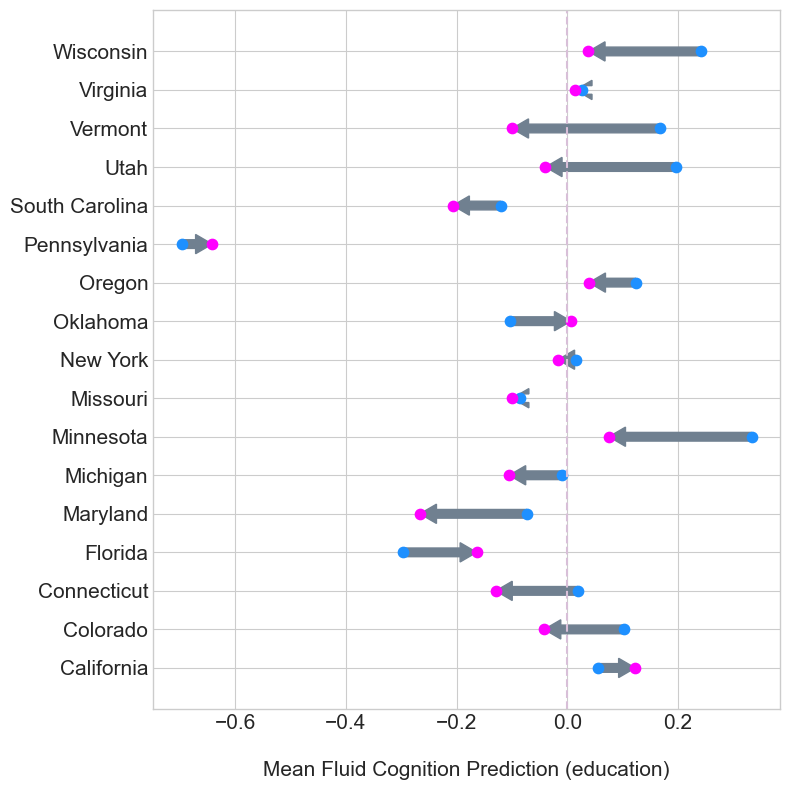

In [65]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (education)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_edu_fluid_ps_state_cognition_results_f4_v2.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [63]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3158526972366307,
  -0.3139762040108065,
  -0.11887011156597369,
  -0.004972305953385505,
  0.11589971156092219],
 [0.03777369347253161,
  -0.2969881381945828,
  -0.02593046773644686,
  0.032829264439272844,
  -0.04705749919777141])

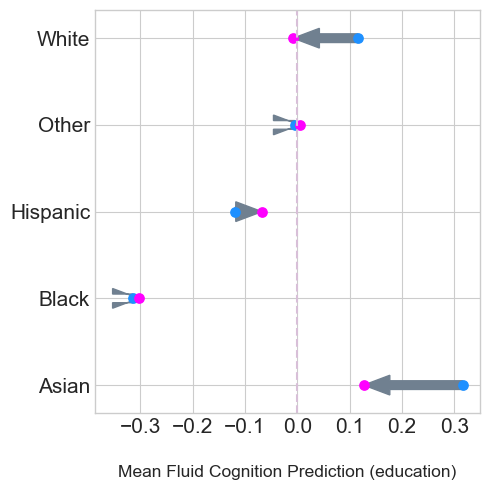

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (education)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_edu_fluid_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_90363/4141950744.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_90363/4141950744.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


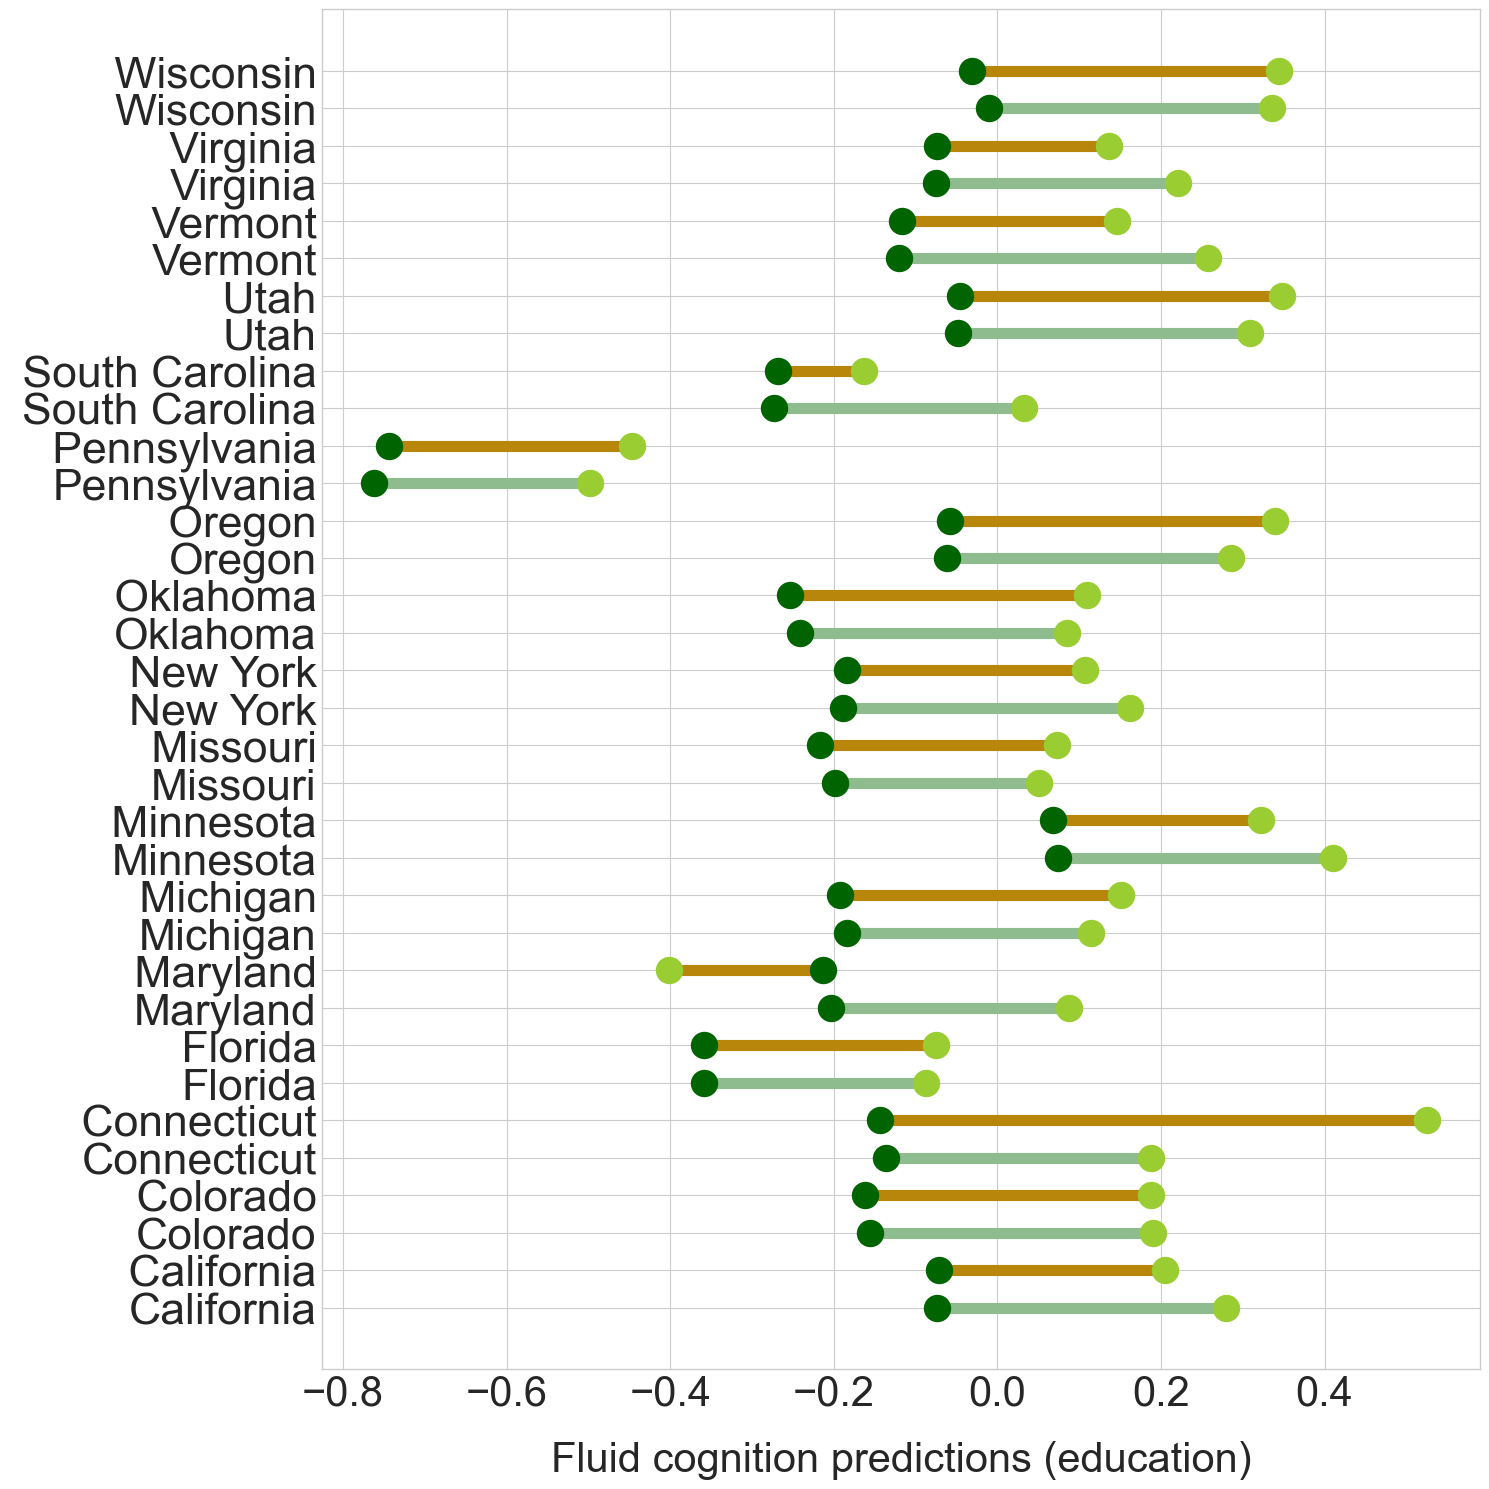

In [64]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_edu_fluid_ps_state_cognition_results_f5_v2.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57211/530562252.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57211/530562252.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


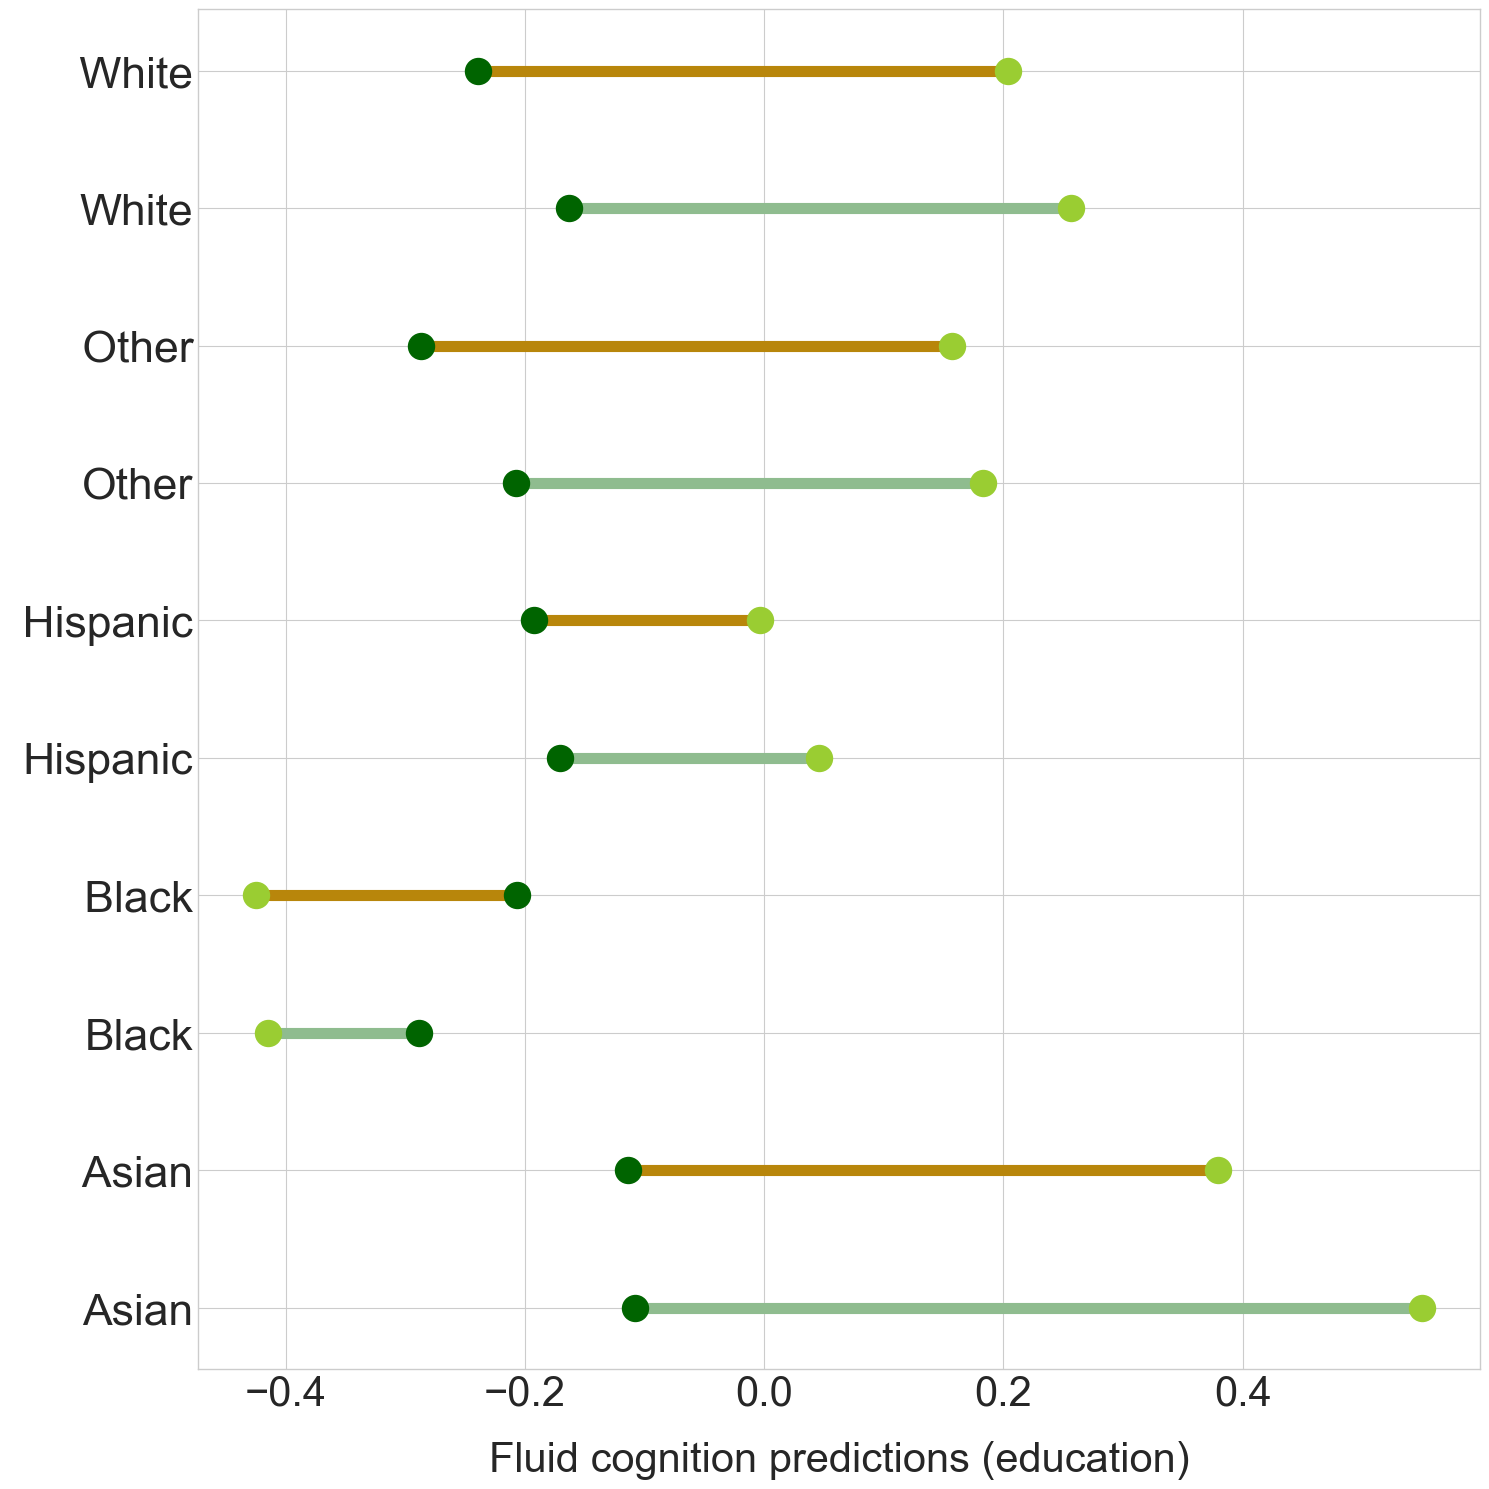

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_edu_fluid_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()